# Multi-File Linguistic Analysis - Dementia Dataset
This notebook processes JSON files from the dementia folder and performs linguistic analysis on character memory retellings across different ages. Each file contains a character's stories at different ages along with their deterioration onset age.

## Import Required Libraries

In [16]:
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy import stats

from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download required NLTK data
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)

True

## Load All JSON Files from Dementia Folder

In [17]:
def load_json_files_from_folder(folder_path):
    """Load all JSON files from a specified folder."""
    json_files = glob.glob(os.path.join(folder_path, "*.json"))
    all_data = []
    
    for file_path in json_files:
        try:
            with open(file_path, 'r', encoding='utf-8') as file:
                data = json.load(file)
                all_data.append(data)
                character_name = data.get('name', 'Unknown')
                start_deterioration_age = data.get('start_deterioration_age', 'Unknown')
                print(f"Loaded: {os.path.basename(file_path)} - Character: {character_name} - Start deterioration age: {start_deterioration_age}")
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    
    return all_data

# Load all JSON files from the dementia data folder
data_folder = "data_aug_10/dementia"
all_character_data = load_json_files_from_folder(data_folder)

print(f"\nLoaded {len(all_character_data)} character files.")

Loaded: Robert Elias Garner.json - Character: Robert Elias Garner - Start deterioration age: 72
Loaded: Anthony Samuel Reyes.json - Character: Anthony Samuel Reyes - Start deterioration age: 72
Loaded: Jessica Marie Holloway.json - Character: Jessica Marie Holloway - Start deterioration age: 75
Loaded: Mark Edward Thompson.json - Character: Mark Edward Thompson - Start deterioration age: 69
Loaded: George Leonard.json - Character: George Leonard - Start deterioration age: 75
Loaded: Jacob Stein.json - Character: Jacob Stein - Start deterioration age: 69
Loaded: James Whitaker.json - Character: James Whitaker - Start deterioration age: 72
Loaded: Keren Aliza Hadar.json - Character: Keren Aliza Hadar - Start deterioration age: 72
Loaded: Olivia Margaret Chen.json - Character: Olivia Margaret Chen - Start deterioration age: 72
Loaded: Lisa Carmen Alvarez.json - Character: Lisa Carmen Alvarez - Start deterioration age: 69

Loaded 10 character files.


## Aggregate Retellings Across All Files

In [18]:
def aggregate_stories_with_years_before_diagnostic(all_character_data):
    """
    Combine all stories from all characters and calculate years before diagnostic.
    Each story becomes a data point with its years before diagnostic based on individual character's start_deterioration_age.
    """
    all_story_points = []
    
    for character_data in all_character_data:
        character_name = character_data.get('name', 'Unknown')
        stories = character_data.get('stories', [])
        deterioration_age = character_data.get('start_deterioration_age')
        
        if deterioration_age is None:
            print(f"Warning: No deterioration age found for {character_name}, skipping...")
            continue
        
        for story_data in stories:
            age = story_data.get('age')
            story = story_data.get('story', '')
            if age is not None and story:
                years_before_diagnostic = -(deterioration_age - age)
                all_story_points.append({
                    'character': character_name,
                    'age': age,
                    'deterioration_age': deterioration_age,
                    'years_before_diagnostic': years_before_diagnostic,
                    'story': story
                })
    
    return all_story_points

# Aggregate all stories with years before diagnostic calculation using individual deterioration ages
all_story_data = aggregate_stories_with_years_before_diagnostic(all_character_data)

# Display summary
print(f"Total story data points: {len(all_story_data)}")
if all_story_data:
    years_before_range = [point['years_before_diagnostic'] for point in all_story_data]
    print(f"Years before diagnostic range: {min(years_before_range)} to {max(years_before_range)}")

    # Show sample data points
    print(f"\nSample data points:")
    for i, point in enumerate(all_story_data[:5]):
        print(f"  {point['character']} - Age {point['age']} (deterioration starts at {point['deterioration_age']}) -> {point['years_before_diagnostic']} years before diagnostic")
        print(f"    Story length: {len(point['story'])} characters")

    # Show distribution by character
    character_counts = {}
    for point in all_story_data:
        char = point['character']
        character_counts[char] = character_counts.get(char, 0) + 1
    
    print(f"\nStory distribution by character:")
    for char, count in character_counts.items():
        # Get deterioration age from the original data
        deterioration_age = next((data['start_deterioration_age'] for data in all_character_data if data.get('name') == char), 'Unknown')
        print(f"  {char}: {count} stories (deterioration starts at age {deterioration_age})")
else:
    print("No story data found!")

Total story data points: 60
Years before diagnostic range: -15 to 6

Sample data points:
  Robert Elias Garner - Age 60 (deterioration starts at 72) -> -12 years before diagnostic
    Story length: 1503 characters
  Robert Elias Garner - Age 63 (deterioration starts at 72) -> -9 years before diagnostic
    Story length: 844 characters
  Robert Elias Garner - Age 66 (deterioration starts at 72) -> -6 years before diagnostic
    Story length: 492 characters
  Robert Elias Garner - Age 69 (deterioration starts at 72) -> -3 years before diagnostic
    Story length: 369 characters
  Robert Elias Garner - Age 72 (deterioration starts at 72) -> 0 years before diagnostic
    Story length: 250 characters

Story distribution by character:
  Robert Elias Garner: 6 stories (deterioration starts at age 72)
  Anthony Samuel Reyes: 6 stories (deterioration starts at age 72)
  Jessica Marie Holloway: 6 stories (deterioration starts at age 75)
  Mark Edward Thompson: 6 stories (deterioration starts at 

## Plotting Utility Function

In [19]:
def plot_scatter_with_regression(story_data, metric_function, label_y: str, title_suffix: str = ""):
    """Plot scatter plot of individual stories with linear regression trend line."""
    if not story_data:
        print(f"No data available for {label_y}")
        return
    
    # Calculate metric for each story
    x_values = []  # years before diagnostic
    y_values = []  # metric values
    characters = []
    
    for story_point in story_data:
        metric_value = metric_function(story_point['story'])
        x_values.append(story_point['years_before_diagnostic'])
        y_values.append(metric_value)
        characters.append(story_point['character'])
    
    if not x_values:
        print(f"No valid data points for {label_y}")
        return
    
    plt.figure(figsize=(12, 8))
    
    # Create scatter plot with different colors for each character
    unique_characters = list(set(characters))
    colors = plt.cm.tab10(range(len(unique_characters)))
    
    for i, character in enumerate(unique_characters):
        char_mask = [c == character for c in characters]
        char_x = [x for x, mask in zip(x_values, char_mask) if mask]
        char_y = [y for y, mask in zip(y_values, char_mask) if mask]
        
        plt.scatter(char_x, char_y, alpha=0.7, s=60, 
                   color=colors[i], label=character, edgecolors='black', linewidth=0.5)
    
    # Add linear regression trend line
    if len(x_values) > 1:
        z = np.polyfit(x_values, y_values, 1)
        p = np.poly1d(z)
        x_trend = np.linspace(min(x_values), max(x_values), 100)
        plt.plot(x_trend, p(x_trend), "r--", alpha=0.8, linewidth=2, label='Linear Trend')
        
        # Calculate and display correlation coefficient and p-value
        from scipy import stats
        correlation, p_value = stats.pearsonr(x_values, y_values)
        significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
        
        plt.text(0.02, 0.98, f'Correlation: {correlation:.3f} ({significance})\np-value: {p_value:.4f}', 
                transform=plt.gca().transAxes, fontsize=10, 
                verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    # Standardize x-axis ticks and limits
    plt.xlim(-16, 10)
    plt.xticks(range(-15, 10, 3))
    plt.xlabel('Years Before Diagnostic', fontsize=12)
    plt.ylabel(f'{label_y}', fontsize=12)
    plt.title(f'{label_y} vs Years Before Diagnostic{title_suffix}', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

def calculate_metric_for_all_stories(story_data, metric_function):
    """Calculate metric for each individual story."""
    story_metrics = []
    
    for story_point in story_data:
        metric_value = metric_function(story_point['story'])
        story_metrics.append({
            'character': story_point['character'],
            'age': story_point['age'],
            'years_before_diagnostic': story_point['years_before_diagnostic'],
            'metric_value': metric_value,
            'story': story_point['story']
        })
    
    return story_metrics

In [34]:
# Helper utilities for linguistic metrics (step 1: noun metric refactor)
from functools import lru_cache
import string

ALPHA = set(string.ascii_lowercase)

def _clean_tokens(text):
    """Lowercase, tokenize, keep only purely alphabetic tokens."""
    tokens = [t.lower() for t in word_tokenize(text)]
    return [t for t in tokens if t.isalpha()]

@lru_cache(maxsize=2048)
def _pos_tags(text):
    toks = _clean_tokens(text)
    return nltk.pos_tag(toks) if toks else []

# NOTE: Other metrics will be progressively migrated to use _clean_tokens / _pos_tags.


## Nouns freq by deterioration age

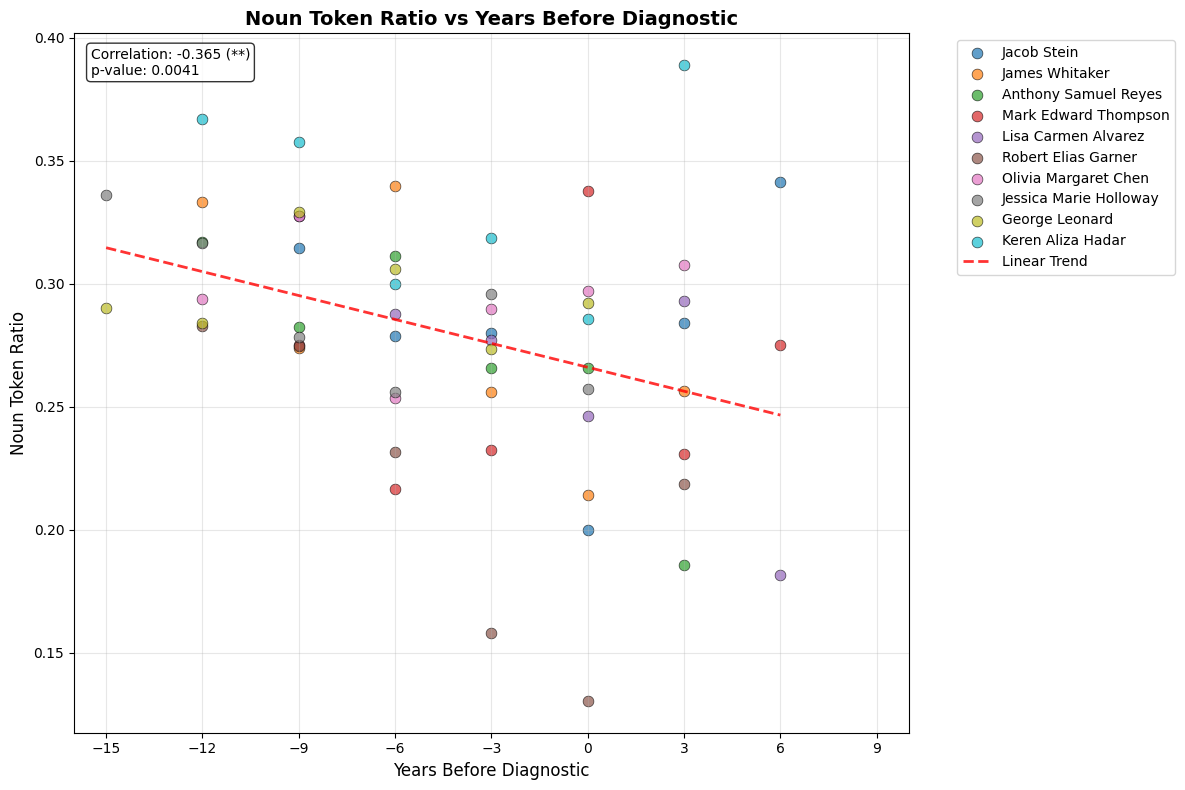

In [35]:
def nouns_freq_in_text(text):
    """Return noun token ratio: proportion of noun POS tokens among cleaned tokens.
    Noun tags counted: NN, NNS, NNP, NNPS.
    Returns 0.0 if no lexical tokens present.
    """
    tags = _pos_tags(text)
    if not tags:
        return 0.0
    noun_tags = {"NN", "NNS", "NNP", "NNPS"}
    noun_count = sum(1 for _, tag in tags if tag in noun_tags)
    return noun_count / len(tags)

# Plot noun token ratio scatter plot
plot_scatter_with_regression(all_story_data, nouns_freq_in_text, "Noun Token Ratio")

## Calculate Hapax Legomena Frequency by Age

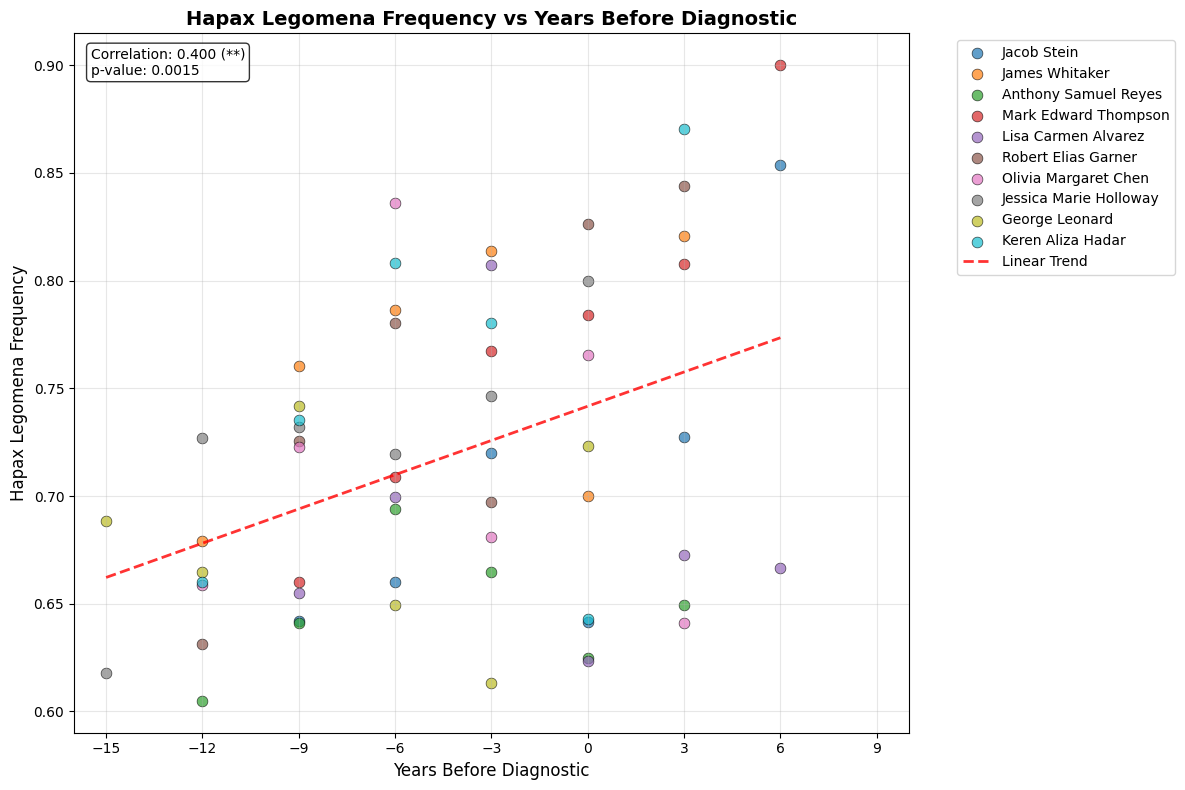

In [36]:
def word_used_once_frequency(text):
    """Hapax legomena ratio: proportion of token types occurring exactly once among cleaned tokens.
    Uses lowercase alphabetic tokens via _clean_tokens.
    Returns 0.0 if no valid tokens.
    """
    tokens = _clean_tokens(text)
    if not tokens:
        return 0.0
    freq = nltk.FreqDist(tokens)
    hapax_count = sum(1 for c in freq.values() if c == 1)
    return hapax_count / len(tokens)

# Plot hapax legomena frequency scatter plot
plot_scatter_with_regression(all_story_data, word_used_once_frequency, "Hapax Legomena Frequency")

## Calculate Words Used Once or Twice Frequency by Age

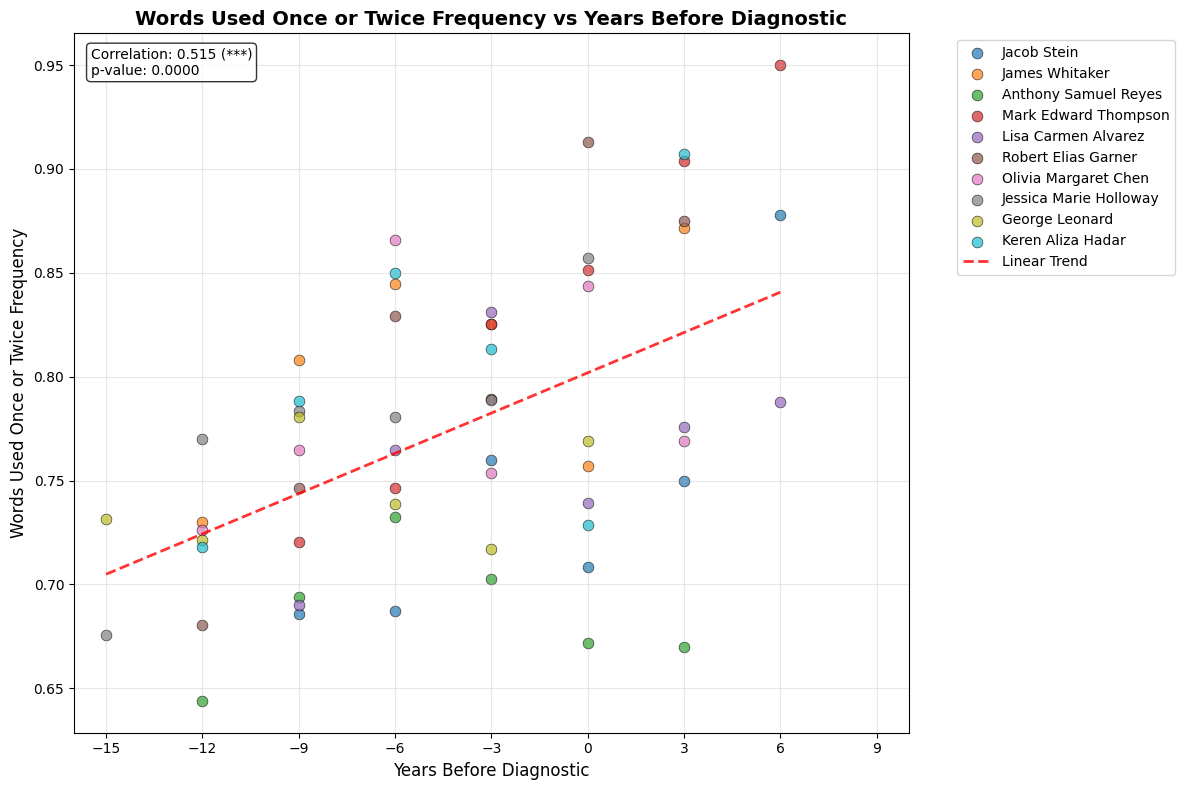

In [37]:
def word_used_once_or_twice_frequency(text):
    """Low-frequency token ratio: proportion of tokens whose type frequency ≤ 2 among cleaned tokens.
    Uses lowercase alphabetic tokens via _clean_tokens.
    Returns 0.0 if no valid tokens.
    """
    tokens = _clean_tokens(text)
    if not tokens:
        return 0.0
    freq = nltk.FreqDist(tokens)
    leq2_count = sum(1 for c in freq.values() if c <= 2)
    return leq2_count / len(tokens)

# Plot words used once or twice frequency scatter plot
plot_scatter_with_regression(all_story_data, word_used_once_or_twice_frequency, "Words Used Once or Twice Frequency")

## Calculate Brunet Index by Age

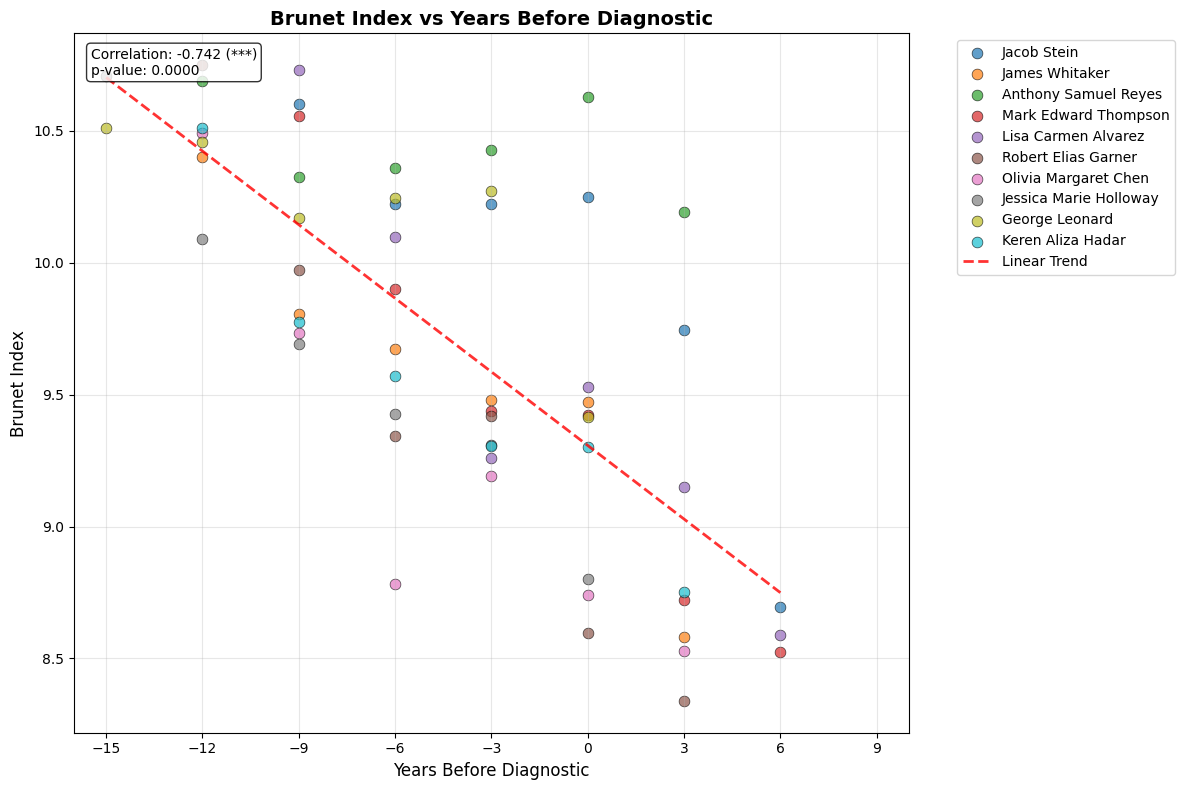

In [42]:
def brunet_index(text, alpha=-0.165):
    """Calculate the Brunet index for the text."""
    tokens = _clean_tokens(text)

    tokens = word_tokenize(text)
    if not tokens:
        return 0
    word_freq = nltk.FreqDist(tokens)
    unique_words = len(word_freq)
    tokens_count = len(tokens)
    if unique_words == 0 or tokens_count == 0:
        return 0
    return tokens_count ** (unique_words ** alpha)

# Plot Brunet index scatter plot
plot_scatter_with_regression(all_story_data, brunet_index, "Brunet Index")

## Calculate Type-Token Ratio by Age

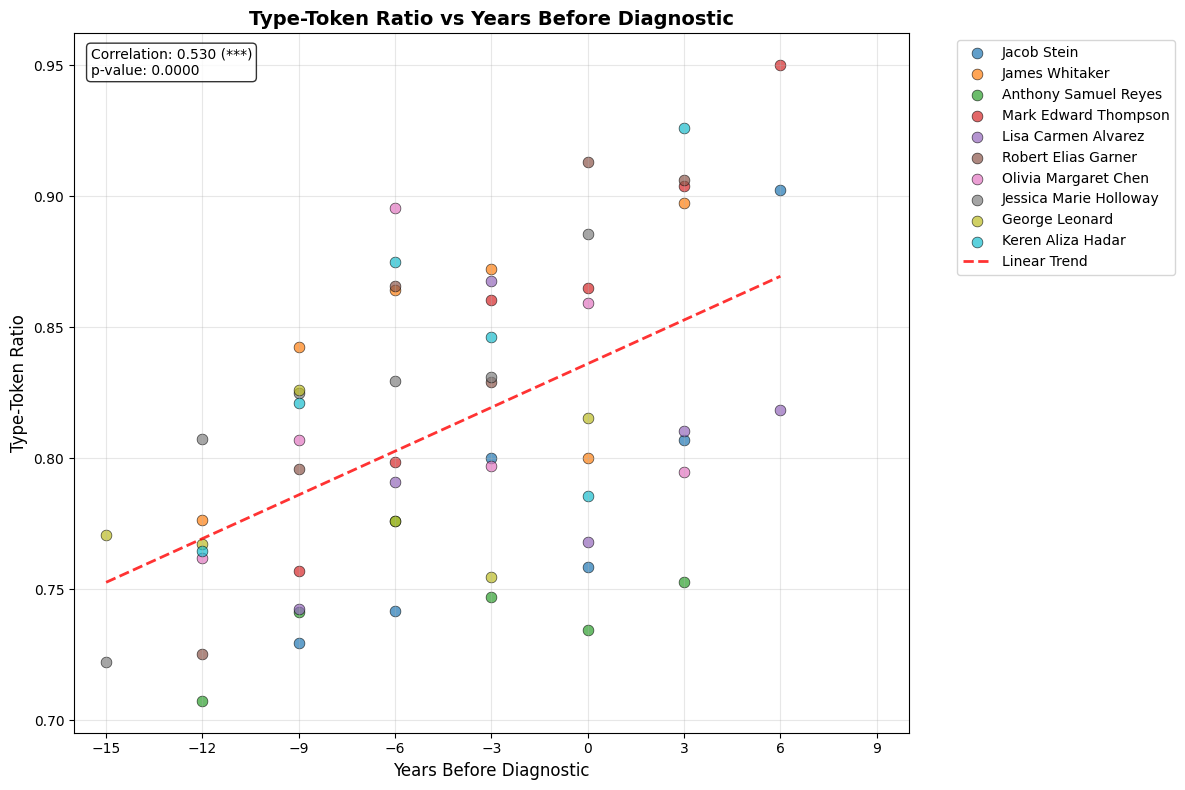

In [44]:
def token_type_ratio(text):
    """Type-Token Ratio (TTR) over cleaned lowercase alphabetic tokens."""
    tokens = _clean_tokens(text)
    N = len(tokens)
    if N == 0:
        return 0.0
    return len(set(tokens)) / N

# Plot type-token ratio scatter plot
plot_scatter_with_regression(all_story_data, token_type_ratio, "Type-Token Ratio")

## Calculate Adposition Frequency by Age

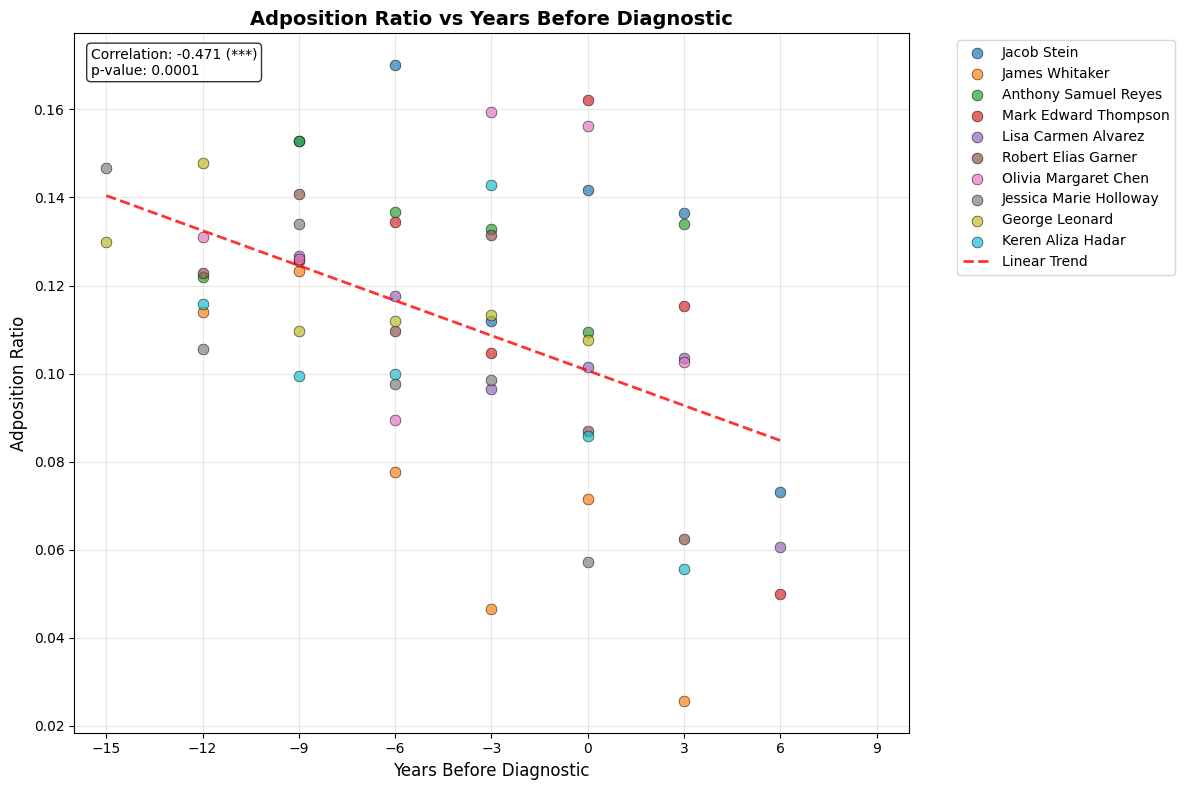

In [47]:
def adposition_frequency(text, include_to: bool = True):
    """Adposition ratio: proportion of adposition POS tags among cleaned tokens.

    Counts Penn Treebank tag 'IN' (prepositions/subordinating conjunctions) and, by default,
    'TO' (the infinitival/particle 'to') when include_to is True.
    Uses cached POS tagging over cleaned alphabetic lowercase tokens.
    Returns 0.0 if no lexical tokens are present.
    """
    tokens = _clean_tokens(text)
    tags = _pos_tags(text)
    if not tags:
        return 0.0
    adp_tags = {"IN"}
    if include_to:
        adp_tags.add("TO")
    adp_count = sum(1 for _, tag in tags if tag in adp_tags)
    return adp_count / len(tokens)

# Plot adposition ratio scatter plot
plot_scatter_with_regression(all_story_data, adposition_frequency, "Adposition Ratio")

## Calculate Unigram and Bigram Repetitions by Age

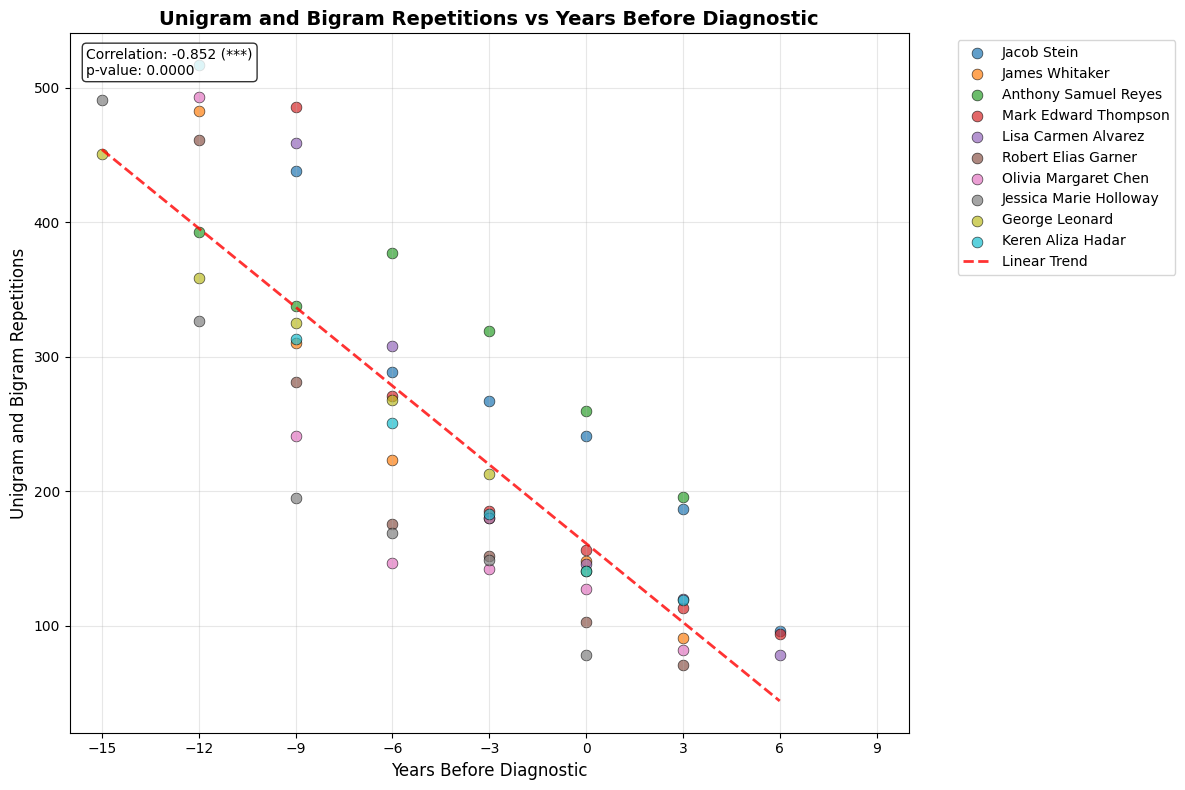

In [51]:
def uni_and_bi_grams_repetitions(text):
    """Calculate the number of unique unigrams and bigrams in the text."""
    tokens = word_tokenize(text)
    if not tokens:
        return 0
    unigrams = nltk.FreqDist(tokens)
    bigrams = nltk.FreqDist(nltk.bigrams(tokens))
    return len(unigrams) + len(bigrams)

# Plot unigram and bigram repetitions scatter plot
plot_scatter_with_regression(all_story_data, uni_and_bi_grams_repetitions, "Unigram and Bigram Repetitions")

## Load Word Frequency Data (CSV)

In [ ]:
def load_csv(file_path):
    """Load a CSV file and return its content."""
    return pd.read_csv(file_path)

# Load word frequency data
try:
    subtl_and_zipf_df = load_csv('subtl_and_zipf.csv')
    # Filter relevant columns
    subtl_and_zipf_df = subtl_and_zipf_df[['Word','FREQcount', 'SUBTLWF', 'Zipf-value']]
    print("Successfully loaded word frequency data.")
    print(f"Shape: {subtl_and_zipf_df.shape}")
    print(subtl_and_zipf_df.describe())
except FileNotFoundError:
    print("Warning: subtl_and_zipf.csv not found. Skipping frequency analysis.")
    subtl_and_zipf_df = None

Successfully loaded word frequency data.
Shape: (74286, 5)
          FREQcount       SUBTLWF    Zipf-value        Lg10WF
count  7.428600e+04  74286.000000  74286.000000  74286.000000
mean   6.692992e+02     13.124088      2.479172      1.187335
std    1.727704e+04    338.765454      0.835829      0.835833
min    1.000000e+00      0.020000      1.592864      0.301000
25%    2.000000e+00      0.040000      1.768955      0.477100
50%    9.000000e+00      0.180000      2.291834      1.000000
75%    4.500000e+01      0.880000      2.954592      1.662800
max    2.134713e+06  41857.120000      7.621174      6.329300


## Calculate SUBTLEX Frequency by Age

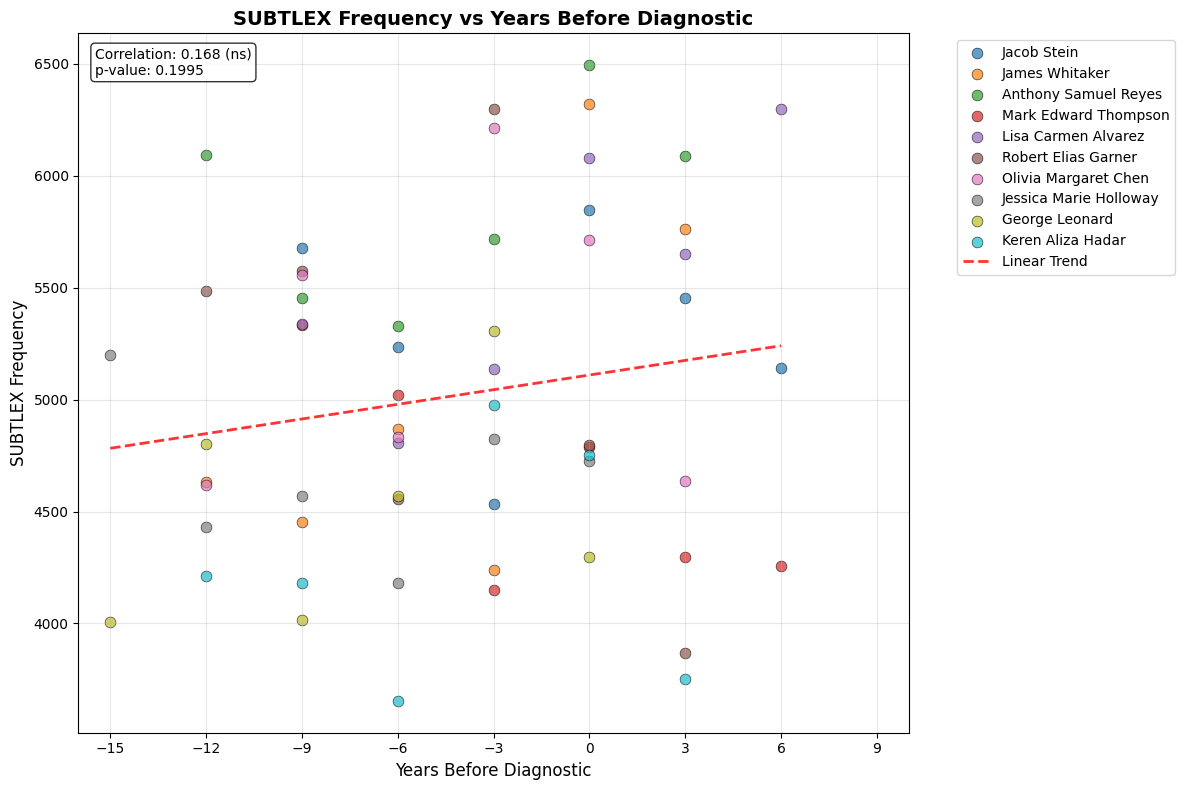

In [69]:
def word_freq_subtl(text, corpus_data):
    """Calculate the frequency of words in the text based on SUBTLEXus data."""
    if corpus_data is None:
        return 0
    
    tokens = _clean_tokens(text)
    if not tokens:
        return 0
    
    word_freq = nltk.FreqDist(tokens)
    total_freq = sum(word_freq.values())
    
    subtl_freq = 0
    for word, freq in word_freq.items():
        matching_rows = corpus_data[corpus_data['Word'] == word]
        if not matching_rows.empty:
            subtl_value = matching_rows['SUBTLWF'].values[0]
            subtl_freq += freq * subtl_value

    return subtl_freq / len(tokens) if total_freq > 0 else 0

# Plot SUBTLEX frequency scatter plot
if subtl_and_zipf_df is not None:
    def subtl_metric(text):
        return word_freq_subtl(text, subtl_and_zipf_df)
    
    plot_scatter_with_regression(all_story_data, subtl_metric, "SUBTLEX Frequency")
else:
    print("Skipping SUBTLEX frequency analysis due to missing data.")

## Calculate Zipf Frequency by Age

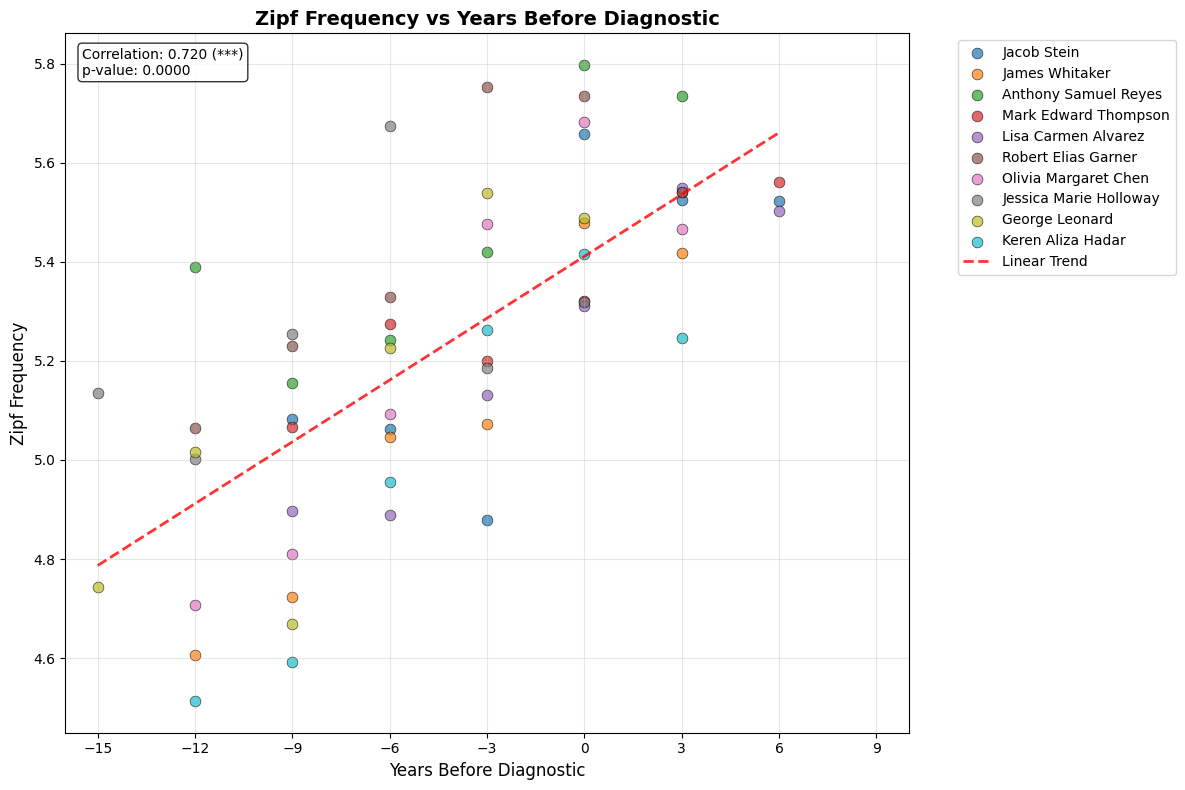

In [60]:
def word_freq_zipf(text, corpus_data):
    """Calculate the frequency of words in the text based on Zipf data."""
    if corpus_data is None:
        return 0

    tokens = _clean_tokens(text)
    if not tokens:
        return 0
    
    word_freq = nltk.FreqDist(tokens)
    total_freq = sum(word_freq.values())
    
    zipf_freq = 0
    for word, freq in word_freq.items():
        matching_rows = corpus_data[corpus_data['Word'] == word]
        if not matching_rows.empty:
            zipf_value = matching_rows['Zipf-value'].values[0]
            zipf_freq += freq * zipf_value
    
    return zipf_freq / total_freq if total_freq > 0 else 0

# Plot Zipf frequency scatter plot
if subtl_and_zipf_df is not None:
    def zipf_metric(text):
        return word_freq_zipf(text, subtl_and_zipf_df)
    
    plot_scatter_with_regression(all_story_data, zipf_metric, "Zipf Frequency")
else:
    print("Skipping Zipf frequency analysis due to missing data.")

## Comprehensive Visualization - All Metrics

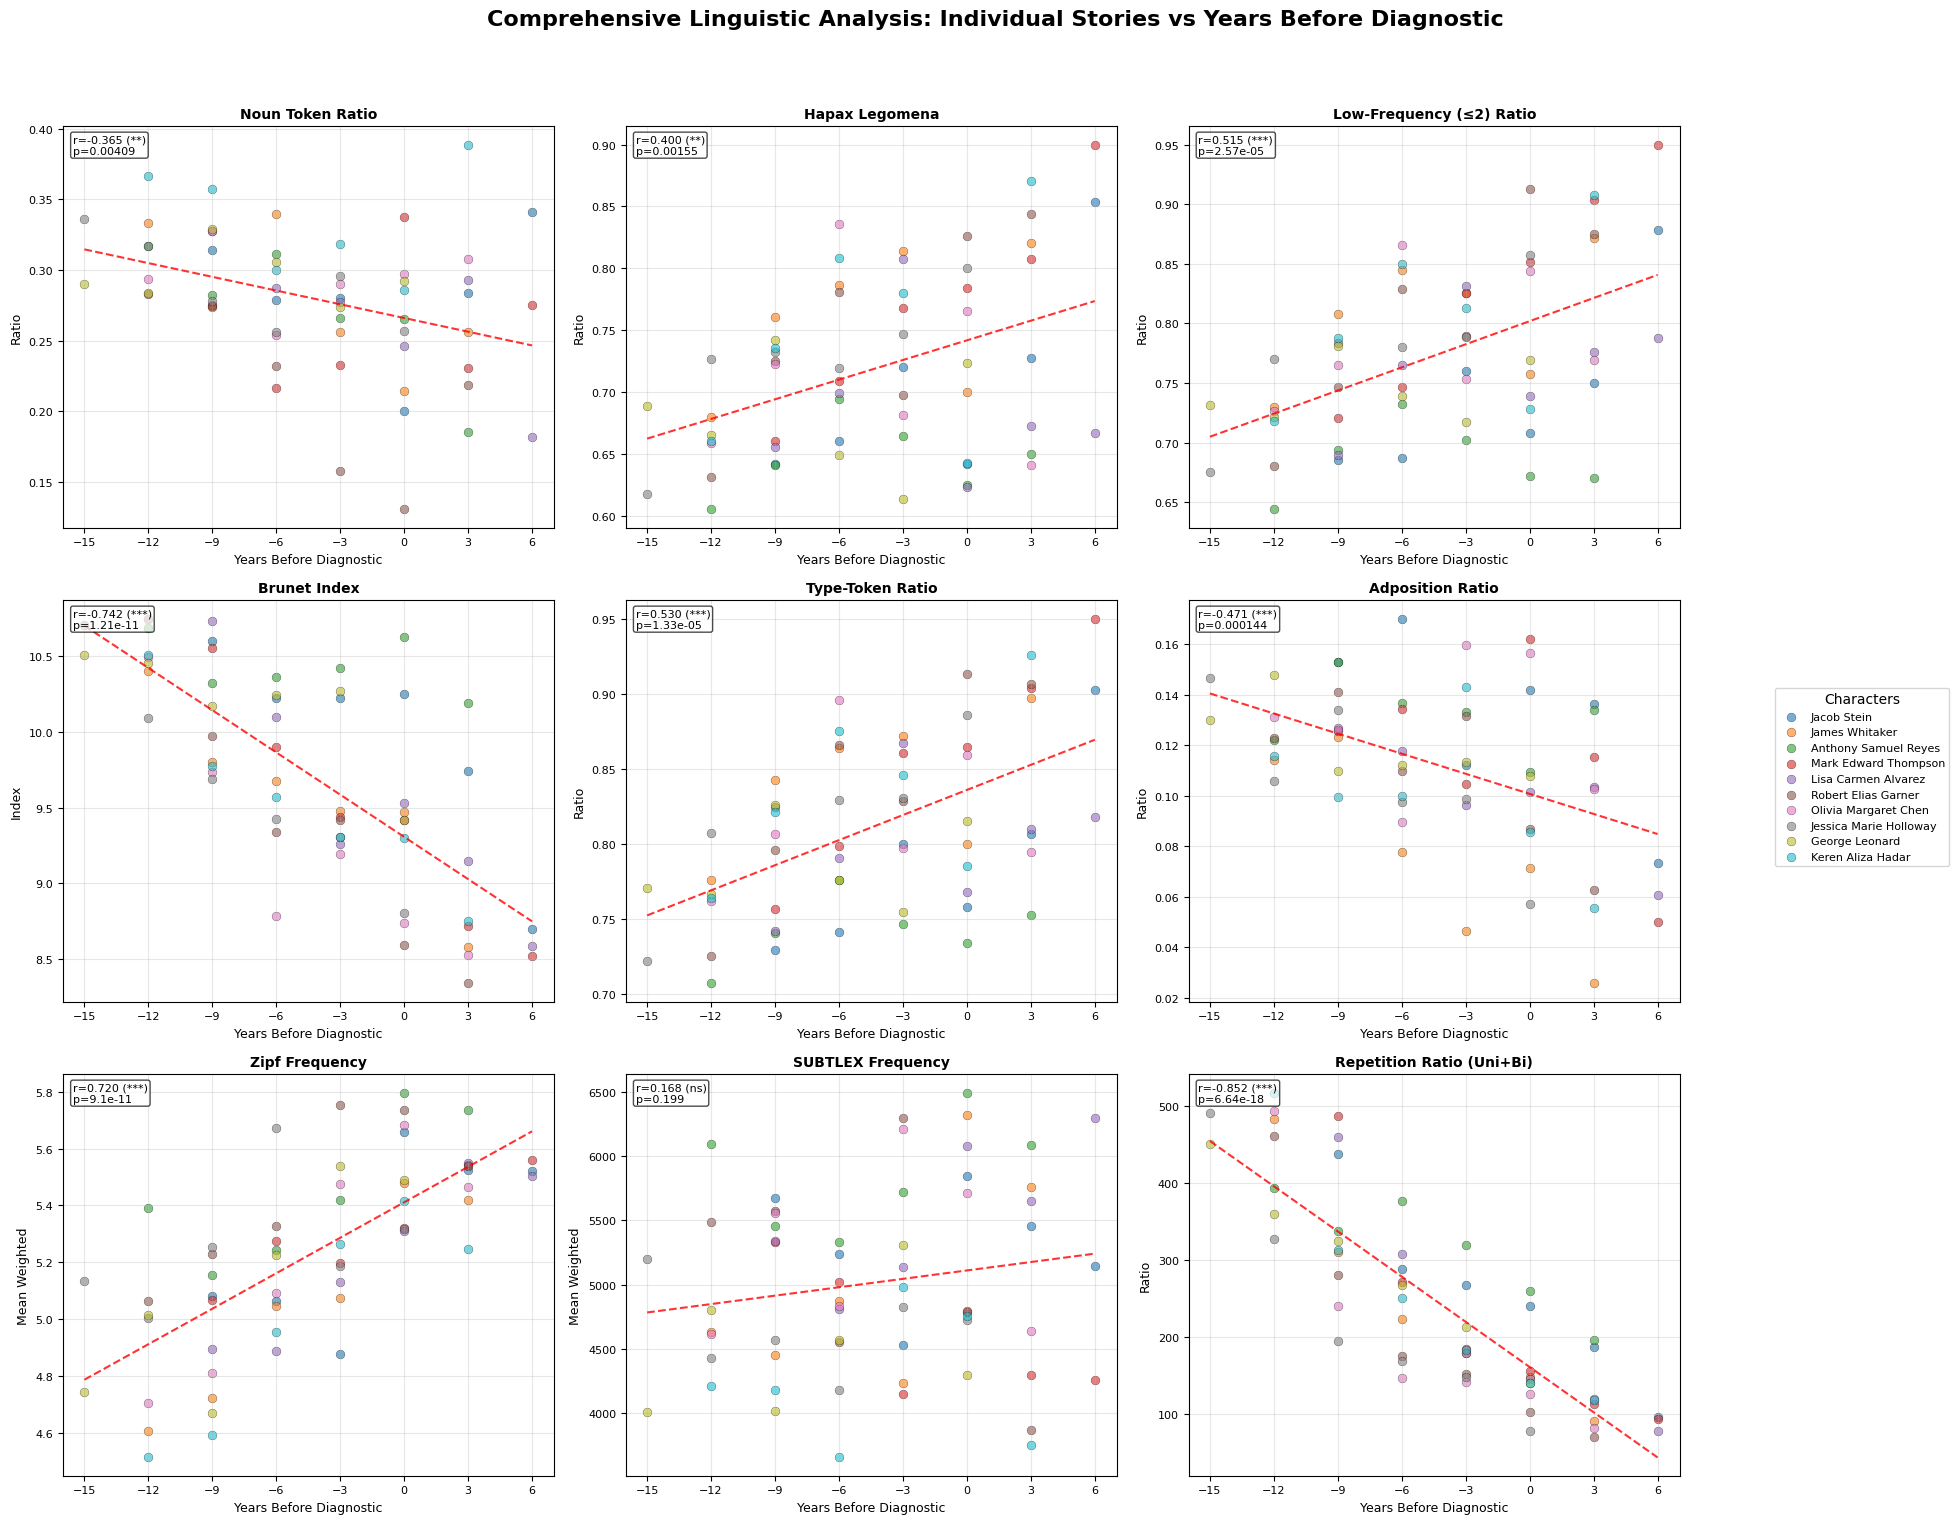

In [70]:
def create_comprehensive_scatter_plot():
    """Create a comprehensive 3x3 subplot showing all linguistic metrics as scatter plots."""
    # Prepare the metric functions (updated labels)
    metric_functions = [
        (nouns_freq_in_text, "Noun Token Ratio", "Ratio"),
        (word_used_once_frequency, "Hapax Legomena", "Ratio"),
        (word_used_once_or_twice_frequency, "Low-Frequency (≤2) Ratio", "Ratio"),
        (brunet_index, "Brunet Index", "Index"),
        (token_type_ratio, "Type-Token Ratio", "Ratio"),
        (adposition_frequency, "Adposition Ratio", "Ratio"),
        (uni_and_bi_grams_repetitions, "Repetition Ratio (Uni+Bi)", "Ratio"),
    ]

    # Add frequency metrics if available (Zipf & SUBTLEX) before repetition ratio for readability
    if subtl_and_zipf_df is not None:
        def zipf_metric(text):
            return word_freq_zipf(text, subtl_and_zipf_df)
        def subtl_metric(text):
            return word_freq_subtl(text, subtl_and_zipf_df)
        metric_functions.insert(6, (subtl_metric, "SUBTLEX Frequency", "Mean Weighted"))
        metric_functions.insert(6, (zipf_metric, "Zipf Frequency", "Mean Weighted"))

    fig, axes = plt.subplots(3, 3, figsize=(20, 16))
    fig.suptitle('Comprehensive Linguistic Analysis: Individual Stories vs Years Before Diagnostic', fontsize=16, fontweight='bold')

    all_characters = list(set(point['character'] for point in all_story_data))
    colors = plt.cm.tab10(range(len(all_characters)))
    character_colors = dict(zip(all_characters, colors))

    for i, (metric_function, title, ylabel) in enumerate(metric_functions):
        row = i // 3
        col = i % 3
        ax = axes[row, col]

        x_values = []
        y_values = []
        characters = []
        for story_point in all_story_data:
            try:
                metric_value = metric_function(story_point['story'])
                x_values.append(story_point['years_before_diagnostic'])
                y_values.append(metric_value)
                characters.append(story_point['character'])
            except Exception:
                continue

        if x_values:
            for character in all_characters:
                char_mask = [c == character for c in characters]
                char_x = [x for x, mask in zip(x_values, char_mask) if mask]
                char_y = [y for y, mask in zip(y_values, char_mask) if mask]
                if char_x:
                    ax.scatter(char_x, char_y, alpha=0.6, s=40,
                               color=character_colors[character], label=character,
                               edgecolors='black', linewidth=0.3)
            if len(x_values) > 1:
                try:
                    z = np.polyfit(x_values, y_values, 1)
                    p = np.poly1d(z)
                    x_trend = np.linspace(min(x_values), max(x_values), 100)
                    ax.plot(x_trend, p(x_trend), "r--", alpha=0.8, linewidth=1.5)
                    from scipy import stats
                    r, p_val = stats.pearsonr(x_values, y_values)
                    sig = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "ns"
                    ax.text(0.02, 0.98, f'r={r:.3f} ({sig})\np={p_val:.3g}',
                            transform=ax.transAxes, fontsize=8,
                            verticalalignment='top',
                            bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.7))
                except Exception:
                    pass
            ax.set_xlabel('Years Before Diagnostic', fontsize=9)
            ax.set_ylabel(ylabel, fontsize=9)
            ax.set_title(title, fontsize=10, fontweight='bold')
            ax.grid(True, alpha=0.3)
            ax.tick_params(labelsize=8)
            ax.set_xticks(np.arange(-15, max(x_values)+1, 3))
            ax.set_xlim(left=-16)
        else:
            ax.text(0.5, 0.5, 'No Data Available', ha='center', va='center', transform=ax.transAxes,
                    fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
            ax.set_title(title, fontsize=10, fontweight='bold')
            ax.set_xlabel('Years Before Diagnostic', fontsize=9)
            ax.set_ylabel(ylabel, fontsize=9)

    handles, labels = axes[0, 0].get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, loc='center right', bbox_to_anchor=(0.98, 0.5),
                   title='Characters', title_fontsize=10, fontsize=8)

    plt.tight_layout(rect=[0, 0.03, 0.85, 0.95])
    plt.show()

# Create the comprehensive scatter plot visualization
create_comprehensive_scatter_plot()